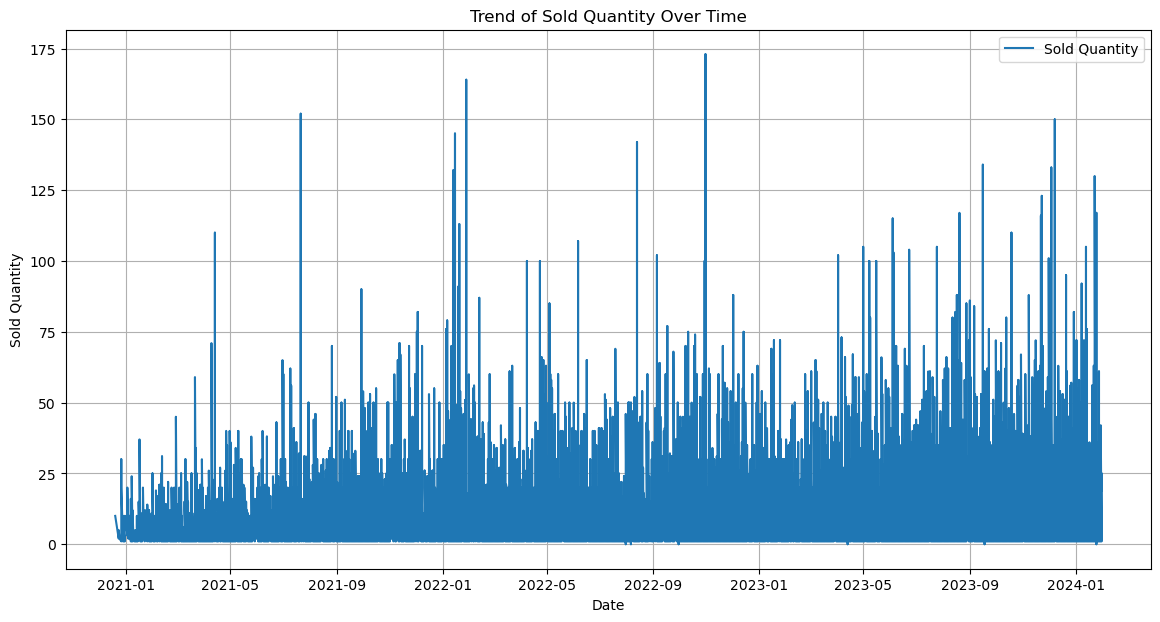

Optimized Sigma: 0.1
Validation RMSE: 9.090500284926431
Test RMSE: 10.23747864911937
                                   Product  Forecasted Quantity
65                Power Cell 500mg Capsule           284.153897
87                     Womens Care Capsule           240.000000
18   EXL Makabuhay Plus Capsule 100&#039;s           235.779368
38  Lianhua Qingwen Jiaonang OTC 24&#039;s           205.333333
26                         H3 Immunity Cap           185.867965
..                                     ...                  ...
83              Vino De Quina Pagoda 330ml             8.000000
84     Virgin Coconut Oil AG Pacific 260ml             8.000000
25                        GroTall Syr 60ml             8.000000
36                      Kings Herbal 500ml             8.000000
64            Pito- Pito Plus ULYLAB 500ml             8.000000

[92 rows x 2 columns]


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from tensorflow.keras.layers import Layer, Input, Dense
from tensorflow.keras.models import Model
from datetime import datetime

# Load your data
df = pd.read_csv('food_supplements.csv')

# Convert 'Sold_date' to datetime format and set as index
df['Sold_date'] = pd.to_datetime(df['Sold_date'], format='%m/%d/%y')
df.set_index('Sold_date', inplace=True)

# Plot the trend of Sold_quantity over time
plt.figure(figsize=(14, 7))
plt.plot(df.index, df['Sold_quantity'], label='Sold Quantity')
plt.xlabel('Date')
plt.ylabel('Sold Quantity')
plt.title('Trend of Sold Quantity Over Time')
plt.legend()
plt.grid(True)
plt.show()

# Instead of aggregating, directly proceed with the existing dataframe
df_encoded = pd.concat([df, pd.get_dummies(df['Product_details'], prefix='product')], axis=1).drop('Product_details', axis=1)

# Extract year and week number from 'Sold_date' for temporal features
df_encoded['year'] = df_encoded.index.year
df_encoded['week_of_year'] = df_encoded.index.isocalendar().week

# Normalize the temporal features 
scaler = MinMaxScaler()
features_columns = ['year', 'week_of_year'] + [col for col in df_encoded.columns if col.startswith('product')]
df_encoded[features_columns] = scaler.fit_transform(df_encoded[features_columns])

# Split the data into features and target
X = df_encoded[features_columns].values
y = df_encoded['Sold_quantity'].values  # Assuming 'Sold_quantity' is the target variable

# Splitting the dataset into training, validation, and testing sets
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.15, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.1765, random_state=42)  # 0.1765 of 85% is roughly 15% of the whole

# Define the Gaussian kernel function
def gaussian_kernel(distance, sigma=0.5):
    return np.exp(-distance**2 / (2 * sigma**2))

# GRNN prediction function
def grnn_predict(X_train, y_train, X_test, sigma=0.5):
    predictions = np.zeros(X_test.shape[0])
    for i, x_test in enumerate(X_test):
        distances = np.linalg.norm(X_train - x_test, axis=1)
        weights = gaussian_kernel(distances, sigma)
        numerator = np.sum(weights * y_train)
        denominator = np.sum(weights)
        predictions[i] = numerator / denominator if denominator > 0 else 0
    return predictions

# Optimizing sigma using the validation set
sigma_values = np.linspace(0.1, 2.0, 20)
sigma_performance = []
for sigma in sigma_values:
    val_predictions = grnn_predict(X_train, y_train, X_val, sigma)
    val_rmse = np.sqrt(mean_squared_error(y_val, val_predictions))
    sigma_performance.append((sigma, val_rmse))
best_sigma, best_val_rmse = min(sigma_performance, key=lambda x: x[1])

# Using the best sigma to make predictions on the test set
predictions = grnn_predict(X_train, y_train, X_test, best_sigma)

# Evaluate the model
test_rmse = np.sqrt(mean_squared_error(y_test, predictions))
print(f'Optimized Sigma: {best_sigma}')
print(f'Validation RMSE: {best_val_rmse}')
print(f'Test RMSE: {test_rmse}')

# Prepare for forecasting
def prepare_forecast_features(date_range, features_columns, scaler):
    forecast_features = []
    for date in date_range:
        feature_vector = np.zeros((1, len(features_columns)))
        year_index = features_columns.index('year')
        week_of_year_index = features_columns.index('week_of_year')
        
        # Normalize year and week_of_year for the forecast date
        feature_vector[0, year_index] = (date.year - scaler.data_min_[year_index]) / (scaler.data_max_[year_index] - scaler.data_min_[year_index])
        feature_vector[0, week_of_year_index] = (date.isocalendar().week - scaler.data_min_[week_of_year_index]) / (scaler.data_max_[week_of_year_index] - scaler.data_min_[week_of_year_index])
        
        forecast_features.append(feature_vector)
        
    return np.vstack(forecast_features)

# Define the forecast period
forecast_start = datetime(2024, 2, 1)
forecast_end = datetime(2024, 2, 8)
forecast_dates = pd.date_range(forecast_start, forecast_end).to_pydatetime().tolist()

# Prepare forecast features
forecast_features = prepare_forecast_features(forecast_dates, features_columns, scaler)

# Making predictions for the forecast period
forecast_predictions = {}
for col in features_columns:
    if col.startswith('product_'):
        product_forecast_features = np.copy(forecast_features)
        product_index = features_columns.index(col)
        
        # Activate current product feature
        product_forecast_features[:, product_index] = 1  # Set the product to active
        
        # Predict with GRNN for the forecast period using the best sigma
        product_predictions = grnn_predict(X_train, y_train, product_forecast_features, best_sigma)
        
        # Aggregate predictions for the product over the forecast period
        forecast_predictions[col.replace('product_', '')] = np.sum(product_predictions)

# Display forecasted quantities for each product
forecast_df = pd.DataFrame(list(forecast_predictions.items()), columns=['Product', 'Forecasted Quantity']).sort_values(by='Forecasted Quantity', ascending=False)
print(forecast_df)


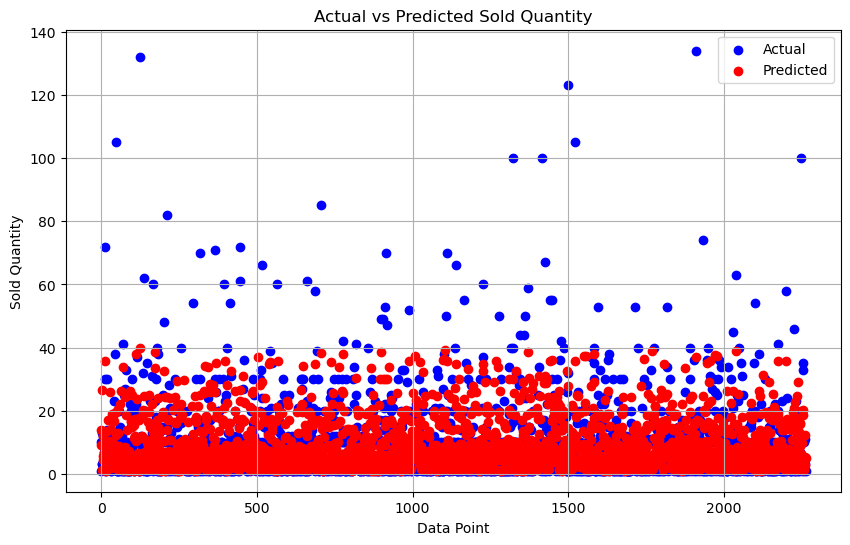

In [2]:
import matplotlib.pyplot as plt

# Assuming 'y_test' contains actual values and 'predictions' contains predicted values
plt.figure(figsize=(10, 6))
plt.scatter(range(len(y_test)), y_test, color='blue', label='Actual')
plt.scatter(range(len(predictions)), predictions, color='red', label='Predicted')
plt.title('Actual vs Predicted Sold Quantity')
plt.xlabel('Data Point')
plt.ylabel('Sold Quantity')
plt.legend()
plt.grid(True)
plt.show()
